<a href="https://colab.research.google.com/github/airesx2/cudaq/blob/main/quick-start-to-quantum/03_quick_start_to_quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quick start to Quantum Computing with CUDA-Q
# Lab 3 - Add a Bit of Variation: Write your first variational program
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

The third and fourth labs in this series culminate with building your first variational hybrid program.  In the first notebook (lab 3), we cover sections 1 and 2.  The second notebook covers the remaining sections.
* Section 1: Comparing Classical Random Walks and Discrete Time Quantum Walk (DTQW)
* Section 2: Programming a variational DTQW with CUDA-Q
* Section 3: Defining Hamiltonians and Computing Expectation Values  
* Section 4: Identify Parameters to Generate a Targeted Mean Value

We begin with the same framework for developing a quantum program as used in Lab 1 and Lab 2, only in this lab we use parameterized gates.  Then, in Lab 4, we adapt this framework into a hybrid quantum-classical workflow to identify parameters that optimize a cost function.  The adapted framework is outlined below:

1. Initialize parameters
2. Encode information into the quantum state by initializing qubit(s)
3. Manipulate the quantum state of the qubit(s) with quantum gate(s) using the  parameters
4. Extract information from the quantum state by measuring the state of the qubit(s) and computing the expectation value of the cost function
5. Run a classical optimizer to either determine a new state of parameters and repeat from step 2, or converge to an optimal solution.

These steps, of what is known as a **variational quantum algorithm**, are outlined in the diagram below.  

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/variational-diagram.png" alt="image of a quantum circuit with the three partsL encode information, manipulate quantum states, extract information" width="700"/>


**What you'll do:**
* Define and visualize discrete time quantum walks for generating probability distributions
* Add variational gates for the coin operators to create your first variational program
* Construct a Hamiltonian that can be used to compute the average of the probability distribution generated by a quantum walk
* Use a classical optimizer to identify optimal parameters in the variational quantum walk that will generate a distribution with a targeted average value

**Terminology you'll use:**
* Computational basis states (basis states for short)
* Probability amplitude
* Statevector
* Control and target for multi-qubit controlled-operations
* Hamiltonian
* Pauli-Z operator

**CUDA-Q syntax you'll use:**
* quantum kernel function decoration: `@cudaq.kernel`
* qubit initialization: `cudaq.qvector` and `cudaq.qubit`
* quantum gates: `x`, `h`, `t`, _`.ctrl`, `cudaq.register_operation`, `u3`
* spin operators: `spin.z`, `spin.i`
* extract information from a kernel: `sample`, `get_state`, _`.amplitude`
* visualization tools: `add_to_bloch_sphere`, `show`, `draw`

Let's begin by installing the necessary packages.

In [ ]:
# Instructions for Google Colab. You can ignore this cell if you have cuda-q set up.
# Run this notebook in a CPU runtime
# Uncomment the line below and execute the cell to install cuda-q
# !pip install cudaq

In [1]:
import cudaq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# install `qutip` in the current Python kernel. Skip this if `qutip` is already installed.
# `matplotlib` is required for all visualization tasks.
# Make sure to restart your kernel if you execute this!
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

# The '\' before the '>' operator is so that the shell does not misunderstand
# the '>' qualifier for the bash pipe operation.

import sys

try:
    import matplotlib.pyplot as plt
    import qutip

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5
    print("\nNew libraries have been installed. Please restart your kernel!")

---
## **Section 1** Comparing Classical Random Walks and Discrete Time Quantum Walk (DTQW)

Quantum walks are a generalization of classical random walks. Unlike classical random walks, where probabilities dictate movement, quantum walks rely on amplitudes. Interference between paths leads to a faster spread over the position space, making quantum walks useful for tasks like quantum search algorithms ([Li and Sun](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.6.033042) and [Wong](https://arxiv.org/pdf/2011.14533)) and for generating probability distributions as we'll explore here.

We begin this section with the definitions of classical random walks and discrete time quantum walks (DTQW). In Section 1.2, we use CUDA-Q to encode an example of a DTQW into a CUDA-Q kernel.

### **Section 1.1** Classical Random Walks

Let's consider a discrete walk taking place on a line. In this scenario, we envision a walker progressing along the
x-axis in discrete increments, with the movement governed by predefined rules based on coin flips.  A classical random walk can be viewed as a decision tree as in the diagram below.  In this scenario, a walker begins in the center of the line. After a coin flip, the walker moves to the left or right depending on the outcome of the coin flip (e.g., flipping a heads will send the walker one step to the left and flipping a tails will send the walk one step to the right).  After `num_time_steps` coin flips, we record the position of the walker.  We repeat this experiment multiple times and generate a histogram of the ending position of the walker in each experiment.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/classical-walk.png" width="400">

Let's see this in action.  Run the code block below to play a video demonstration of the classical random walk with 4 steps.

In [ ]:
# Run this code to watch a short video demonstrating a random walk
# The green dot represents the walker whose movements are dictated by flips of a fair coin
# The ending position from each run of the experiment is recorded in the histogram
from IPython.display import Video

# Path to the MP4 file
video_path = "images/galton_board-coin.mp4"

# Display the video
Video(video_path, embed=True, width = 400)

### **Section 1.2** Disrete Time Quantum Walks

A **discrete-time quantum walk (DTQW)** is the quantum analogue of a classical random walk. In this scenario, both the position of the walker and the coin are represented as quantum states, $\ket{\psi_W}$ and $\ket{\psi_C}$, respectively. Throughout this walk, the state of the walker changes according to a quantum shift operators ($S_+, S_-$) which depend on the state of the coin $\ket{\psi_C}$. In particular, the $S_{-}$ operation checks if $\ket{\psi_C}$ in the state $\ket{0}$ (i.e., heads) and if so, induces a shift left operation on the quantum walker. Similarly, $S_{+}$ is defined for tails and shifting right. At each time step, the state of the coin changes (i.e., is "flipped") via a quantum operation ($F$), which we'll call the coin-flip operator. Unlike the classical random walk, we will not know the position of the walker until the end of the process, when the quantum state of the walker is measured, and we'll never know the state of the coin!

In the diagram below we illustrate a 2-step quantum walk where the coin-flip operator $F$ is the Hadamard gate.  Notice how the final distribution of the walker's possible positions differs from the classical case. In particular, the state of the walker after 2 time steps is in superposition.  Moreover, upon measurement of the final state, the walker never ends up in the location $4 = |0100\rangle$, as might occur with two tails in the classical case depicted above.


<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/dtqw-superposition-coin.png" width="800">


#### The Line that the Walker Traverses
 For our example, let's consider a line that contains $16$ positions, labeled $0,1,\cdots,15$.  We can use $4$ qubits and the computational basis states, ($\ket{\bf{0}} = \ket{0000}, \ket{\bf{1}} = \ket{0001}, \ket{\bf{2}} = \ket{0010}, \cdots, \ket{\bf{15}} = \ket{1111}$), to represent positions on the line.  In other words, the computational basis state $\ket{\bf{i}}$ represents the $i^{th}$ location on the line.


#### The Walker's Position State
The walker's position after $t$ time steps is given by a linear combination of the computational basis states $$\ket{\psi_W(t)} = \sum_{i}\alpha_i(t)\ket{\bf{i}},$$ for some $\alpha_i(t)\in\mathbb{C}$ satisfying $\sum_{i}|\alpha_i(t)|^2 = 1$.  For instance, if the walker began the experiment at position $0$, then the state of the walker at time $0$ would be $\ket{\psi_W(0)}=\ket{0000}$.  More interestingly, the walker might begin the experiment in a superpositon of two or more positions.  For example, the initial state of the walker could be the positions $2$ and $3$.  In this case the walker's initial state is $\ket{\psi_W(0)}=\frac{1}{\sqrt{2}}(\ket{\bf{2}}+\ket{\bf{3}}) = \frac{1}{\sqrt{2}}\ket{0010}+\frac{1}{\sqrt{2}}\ket{0011}$ as depicted in the image below.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/dtqw-superposition-walker.png" width="800">

---
## **Section 2** Programming a variational DTQW with CUDA-Q

Let's start coding up the variational DTQW in CUDA-Q.  This is depicted in the diagram below.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/refs/heads/main/images/dtqw-no-optimization.png" width="800">

We'll explain each portion of this diagram as we work through this section.
First, let's start with the purple optional quantum walker initialization in the upper left hand corner of the diagram.  Edit the code block below to create a kernel that generates the initial state $\ket{\psi_W(0)}=\frac{1}{\sqrt{2}}\ket{0000}+\frac{1}{\sqrt{2}}\ket{1111}$ using an `x` gate and CNOT gates `x.ctrl(control_qubit, target_qubit)`. T

In [3]:
# EXERCISE 1

@cudaq.kernel
def initial_state(qubits : cudaq.qview):
    """ Apply gates to the qubits to prepare the GHZ state
    Parameters
        qubits: cudaq.qvector
        qubits for the walker
    """

    # Edit the code below this line
    h(qubits[0])
    x.ctrl(qubits[0], qubits[1])
    x.ctrl(qubits[0], qubits[2])
    x.ctrl(qubits[0], qubits[3])

    # Edit the code above this line

Let's verify that our solution is correct by using the `cudaq.get_state` and _`.amplitudes` commands.

In [4]:
# Create a quantum kernel that initializes the state of the walker

num_qubits = 4

@cudaq.kernel
def walker(num_qubits : int):
    """ Kernel to initialize the state of the walker
    Parameters
        num_qubits : int
        Number of qubits for the walker
    """
    # Initialize the qubits
    qubits = cudaq.qvector(num_qubits)

    # Apply the initial state to the qubits
    initial_state(qubits)

# Get the state of the walker after applying the quantum kernel
state = cudaq.get_state(walker, 4)

# Return the amplitudes of |0000> and |1111>
state_amplitudes = state.amplitudes([[0,0,0,0], [1,1,1,1]])

# Print
precision = 4
print('Walker state array of coefficients:', np.round(np.array(state), precision))
print('Walker statevector: {} |0000> + {} |1111>'.format(np.round(state_amplitudes[0],precision), np.round(state_amplitudes[1],precision)))

Walker state array of coefficients: [0.7071+0.j 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j
 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j
 0.    +0.j 0.    +0.j 0.    +0.j 0.7071+0.j]
Walker statevector: (0.7071+0j) |0000> + (0.7071+0j) |1111>


#### Walking the Line

The next step (no pun intended) is to code incrementer and decrementer operations, drawn as light green and yellow blocks and denoted by $INC$ and $DEC$ in the diagram.  These will change the state of the walker with shifts to the left and right on the number line.  We'll use these operations to build up the shift operators $S_-$ and $S_+$ which depend on the state of the coin, depticted in the diagram with the control operators.  

First let's define $INC$  so that when applied to a basis state $\ket{x}$, the result is $\ket{(x+1)_{\mod{16}}}$ for $x\in \{0,\cdots 15\}$. The kernel for INC is defined below.  


In [5]:
# Define a kernel on 4 qubits for the INC operation that
# maps |x> to |x+1> mod 16 and verify that it works as expected for |0000>

@cudaq.kernel
def INC(qubits : cudaq.qview):
    x.ctrl([qubits[3], qubits[2], qubits[1]], qubits[0])
    x.ctrl([qubits[3], qubits[2]], qubits[1])
    x.ctrl(qubits[3], qubits[2])
    x(qubits[3])


# Create a kernel that applies the INC to the 4 qubit state |0000>
@cudaq.kernel
def check_incrementer_kernel():
    qubits = cudaq.qvector(4)
    INC(qubits)

# Print the INC circuit
print(cudaq.draw(check_incrementer_kernel))

result = cudaq.sample(check_incrementer_kernel).most_probable()
print('Incrementer kernel |0000> -> |{}>'.format(result))

     ╭───╮               
q0 : ┤ x ├───────────────
     ╰─┬─╯╭───╮          
q1 : ──●──┤ x ├──────────
       │  ╰─┬─╯╭───╮     
q2 : ──●────●──┤ x ├─────
       │    │  ╰─┬─╯╭───╮
q3 : ──●────●────●──┤ x ├
                    ╰───╯

Incrementer kernel |0000> -> |0001>


Using the fact that DEC is the inverse of INC, create the DEC kernel by completing the code block below.

In [6]:
# EXERCISE 2

# Define a kernel on 4 qubits for the DEC operation that
# maps |x> to |x-1> mod 16 and verify that it works as expected for |0001>

@cudaq.kernel
def DEC(qubits : cudaq.qview):
    # Edit the code below this line
    x(qubits[3])
    x.ctrl(qubits[3], qubits[2])
    x.ctrl([qubits[3], qubits[2]], qubits[1])
    x.ctrl([qubits[3], qubits[2], qubits[1]], qubits[0])


    # Edit the code above this line

# Create a kernel that applies the DEC to the 4 qubit state |0000>
@cudaq.kernel
def check_decrementer_kernel():
    qubits = cudaq.qvector(4)
    # Initialize the qubits to |0001>
    x(qubits[3])
    DEC(qubits)

result = cudaq.sample(check_decrementer_kernel).most_probable()
print('Decrementer kernel |0001> -> |{}>'.format(result))

Decrementer kernel |0001> -> |0000>


#### The State of the Coin

Not only is the position of the walker at any given time step a linear combination of the computational basis states, but also the coin is a linear combinations of heads:

$$\ket{\uparrow} \equiv \ket{0} = \begin{pmatrix}1 \\ 0 \end{pmatrix}$$

and tails:

$$\ket{\downarrow} \equiv \ket{1} = \begin{pmatrix}0 \\ 1 \end{pmatrix}$$

and depends on $t$: $$\ket{\psi_C(t)} = \beta_0(t)\ket{0}+\beta_1(t)\ket{1},$$ for $\beta_0,\beta_1\in\mathbb{C}$ with $|\beta_0(t)|^2 + |\beta_1(t)|^2 = 1.$  In case it helps to think of this qubit as "heads up" and "heads down" and distinguish it from the position state, we introduced the alternative (and optional) notation $\ket{\uparrow}$ and $\ket{\downarrow}$ for the zero-state (heads up) and the one-state (heads down), respectively.

Let's look at a couple of examples. We might begin the experiment with a coin in the zero (heads) state: $\ket{\psi_C(0)}=\ket{0}$.  Another option would be to start the experiment with the coin in a state of superposition of both heads and tails: $\ket{\psi_W(0)}=\frac{1}{\sqrt{2}}\ket{0}+\frac{1}{\sqrt{2}}\ket{1}\equiv\ket{+}$.

#### Changing the State of the Coin

The flipping of the coin is carried out by a quantum operation, $F$.  If the coinflip operation is the bitflip operation, $X$,
and the initial state of the coin is $\ket{\psi_C(0)} = \ket{0}$, then, flipping the coin would just change the state from $\ket{0}$ to $\ket{1}$ &mdash; much like the classical random walk.   

A common and more interesting quantum coinflip operation is the Hadamard operator, $F=H$, as illustrated in the diagrams of the DTQW that appeared earlier in this notebook.
Applying this operator iteratively to the coin in the initial state $\ket{\psi_C(0)} = \ket{0}$, will result in alternating coin states $\ket{+}$ and $\ket{0}$.  The initializing the state of the coin is depicted in the diagram as a purple block on the lower left corner.




We're not limited to constant coin operators, and could consider a coin operator that depends on parameters such as the Grover operator used for searching a graph for marked vertices ([Li and Sun](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.6.033042) and [Wong](https://arxiv.org/pdf/2011.14533)). Moreover, the coin operator might depend on parameters that change from one step to the next and can be learnable ([Chang et al., 2023](https://arxiv.org/pdf/2302.12500) [Chang et al., 2025](https://arxiv.org/pdf/2504.13532)), as we'll see in the next example.

So far we have considered single-qubit operations that rotate the Bloch sphere by a fixed amount.  For instance the `x`-gate corresponds to a rotation of the Bloch sphere about the $x$-axis by 180 degrees, and the `t`-gate rotates a statevector 45 degrees about the $Z$-axis.  What about all the other rotation angles and all the other axis of rotation?  The `u3`-gate is a universal rotation gate that allows us to define arbitrary rotation gates.  The unitary matrix for this gate is:

$$ U_3(\theta, \varphi,\lambda) = \begin{pmatrix} \cos{\frac{\theta}{2}} &  -e^{i\lambda}\sin{\frac{\theta}{2}} \\  
                         e^{(i\varphi} \sin{\frac{\theta}{2}} &    e^{i(\lambda + \varphi)} \cos{\frac{\theta}{2}} \end{pmatrix},$$

where $\theta$, $\varphi$, and $\lambda$ are variables which we will assign values to before executing the kernel. We've drawn this as a dark green block in the diagram.

Experiment with different gates and different values of $\theta$, $\varphi$, and $\lambda$ in the code block below to see the effect of a coin flip defined by the `u3`-gate on a coin which is initiated in the heads up, zero-state.

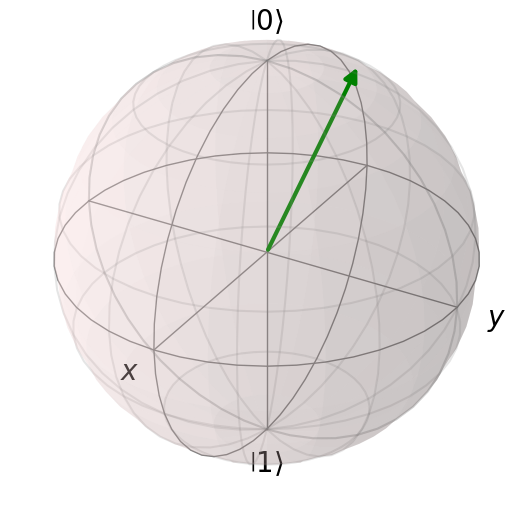

In [7]:
# Coin flip with the u3-gate applied to a coin in the zero-state

# theta = np.pi/2 and phi = Lambda = 0 is the Hadamard gate
theta = np.pi/4    #CHANGE ME
phi = 3             #CHANGE ME
Lambda = 1      #CHANGE ME

# Parameterized kernel for the coin flip
@cudaq.kernel
def coin_flip_with_u(theta : float, phi : float, Lambda: float):

    # Initialize the coin state
    coin_qubit = cudaq.qubit()

    # Apply a coin flip with the u3-gate and given parameters
    u3(theta, phi, Lambda, coin_qubit)



# Get the state of the coin after the flip
coin_flip_result = cudaq.get_state(coin_flip_with_u, theta, phi, Lambda)

cudaq.show(cudaq.add_to_bloch_sphere(coin_flip_result))



#### Changing the State of the Walker Based on Coin Flips:

Now we're ready to put all of these kernels together to program one step of the DTQW.  Let's set the initial state of the walker to be $\ket{\psi_W(0)} = \ket{0101}$. The steps $S_+$ and $S_-$, which depend on the state of the coin, can be modeled with controlled-gates and the INC and DEC operations, respectively.  We've defined the $S_+$ step below, which uses a controlled-gate to apply INC to the walker state, if the coin is in the one-state $\ket{\uparrow}$.  How would you adapt the code to call up the $DEC$ operator, when the coin qubit is in the $\ket{0}$ state?


In [8]:
# EXERCISE 3
# Fill in the code to carry out the S- step

# Pick your favorite values
theta = np.pi/2     #CHANGE ME
phi = np.pi*4      #CHANGE ME
lam = 3.9          #CHANGE ME

# Set the number of qubits
num_qubits = 4

@cudaq.kernel
def DTQW_one_step(num_qubits: int, theta : float, phi : float, lam : float):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qvector(1)
    # Initial walker state |0101>
    x(walker_qubits[1])
    x(walker_qubits[3])

    # Initial coin state
    h(coin_qubit[0]) #Uncomment this line to start with a superposition of heads and tails instead of |0>

    # One quantum walk step
    # Coin operation F=u3
    u3(theta, phi, lam, coin_qubit)

    # Walker's position change
    # Shift right (S+) when the coin is |1>
    cudaq.control(INC, coin_qubit[0], walker_qubits)

    # Shift left (S-) when the coin is |0>
    # EDIT CODE BELOW THIS LINE
    x(coin_qubit[0]) #flip to 1 state
    cudaq.control(DEC, coin_qubit[0], walker_qubits)
    x(coin_qubit[0]) #flip back

    # EDIT CODE ABOVE THIS LINE

    mz(walker_qubits)

# Visualize the kernel for the quantum walk
print(cudaq.draw(DTQW_one_step, num_qubits, theta, phi, lam))

# Sample the kernel for the quantum walk
result = cudaq.sample(DTQW_one_step, num_qubits, theta, phi, lam, shots_count=1000)
print(result)

                                 ╭───╮                                   ╭───╮»
q0 : ────────────────────────────┤ x ├───────────────────────────────────┤ x ├»
     ╭───╮                       ╰─┬─╯╭───╮                         ╭───╮╰─┬─╯»
q1 : ┤ x ├─────────────────────────●──┤ x ├─────────────────────────┤ x ├──●──»
     ╰───╯                         │  ╰─┬─╯╭───╮               ╭───╮╰─┬─╯  │  »
q2 : ──────────────────────────────●────●──┤ x ├───────────────┤ x ├──●────●──»
     ╭───╮                         │    │  ╰─┬─╯╭───╮     ╭───╮╰─┬─╯  │    │  »
q3 : ┤ x ├─────────────────────────●────●────●──┤ x ├─────┤ x ├──●────●────●──»
     ├───┤╭─────────────────────╮  │    │    │  ╰─┬─╯╭───╮╰─┬─╯  │    │    │  »
q4 : ┤ h ├┤ u3(1.571,12.57,3.9) ├──●────●────●────●──┤ x ├──●────●────●────●──»
     ╰───╯╰─────────────────────╯                    ╰───╯                    »

################################################################################

     
─────
     
─────
     
─────
 

The code block below helps us to visualize the results of the sampling:

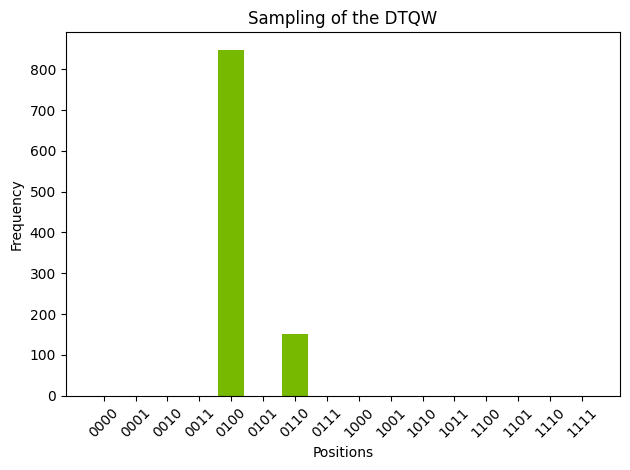

In [9]:
# Define a function to draw the histogram of the results

def plot_results(result, num_qubits):
    # Define a dictionary of results

    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length num_qubits
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    # Update the results dictionary of results from the circuit sampling
    for k,v in result.items():
        result_dictionary[k] = v

    # Convert the dictionary to lists for x and y values
    x = list(result_dictionary.keys())
    y = list(result_dictionary.values())

    # Create the histogram
    plt.bar(x, y, color='#76B900')

    # Add title and labels
    plt.title("Sampling of the DTQW")
    plt.xlabel("Positions")
    plt.ylabel("Frequency")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_results(result, num_qubits)

Go ahead and experiment with the single DTQW code above by changing the parameter values and initial position to get a sense of how the $S_+$ and $S_-$ operators work.

Your next task is to edit the code below to perform `num_time_steps` iterations of the quantum walk, sample the outcomes, and plot a histogram of the final position state. Keep in mind that you cannot embed DTQW_one_step within a loop, as the DTQW algorithm prescribes taking a single measurement only after completing all steps, rather than after each individual step.

{ 0001:178 0011:24 0101:33 0111:54 1001:16 1011:26 1101:382 1111:287 }



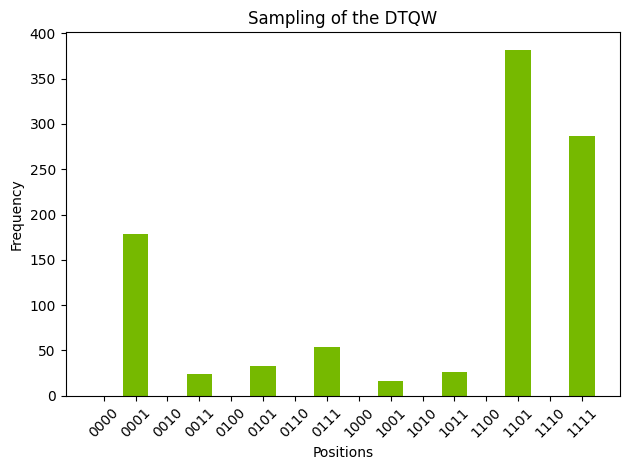

In [10]:
# EXERCISE 4

# Set a variable for the number of time steps
num_time_steps = 3000 # CHANGE ME to see the effect of different length walks

# Pick your favorite values
theta = np.pi/4     #CHANGE ME
phi = np.pi/4       #CHANGE ME
lam = 0.0          #CHANGE ME

# Set the number of qubits
num_qubits = 4

# EDIT CODE BELOW THIS LINE

@cudaq.kernel()
def DTQW_multi_step(num_qubits: int, theta : float, phi : float, lam : float, num_time_steps : int):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qvector(1)
    # Initial walker state |0101>
    x(walker_qubits[1])
    x(walker_qubits[3])

    # Initial coin state
    #h(coin_qubit[0]) #Uncomment this line to start with a superposition of heads and tails instead of |0>

    # Flip the coin num_time_steps and shift the walker accordingly
    # A simple for loop works !
    # Initially, I thought there would be a problem with unrolling but Cudaq seems to handle that
    for i in range(num_time_steps):
        u3(theta, phi, lam, coin_qubit)

        # Shift right (S+) when the coin is |1>
        cudaq.control(INC, coin_qubit[0], walker_qubits)

        # Shift left (S-) when the coin is |0>
        x(coin_qubit[0])
        cudaq.control(DEC, coin_qubit[0], walker_qubits)
        x(coin_qubit[0])

    # Measure the state of the walker
    mz(walker_qubits)

# EDIT CODE ABOVE THIS LINE

# Sample the kernel for the quantum walk
result_multi_step = cudaq.sample(DTQW_multi_step, num_qubits, theta, phi, lam, num_time_steps, shots_count=1000)
print(result_multi_step)

# Draw the histogram of the results after one step
plot_results(result_multi_step, num_qubits)

Change the initial walker's position and parameter values for the coin flip operator to see the variety of distributions that can be generated with a quantum random walk.  

Our next goal will be to use the quantum random walk to load a probability distribution into a quantum state.  This will require us to be able to match a given probability distribution with parameter values that will generate that distribution.  To do this, we'll use a classical optimizer.  That's the challenge of the next notebook.